In [134]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import ydata_profiling
from time import time
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics


kmf = KaplanMeierFitter()
cph = CoxPHFitter()


import warnings
warnings.filterwarnings('ignore')

playlist_data = pd.read_csv("../Super_Grp_1_Proj_3/InjuryData/PlayList.csv")
injury_data = pd.read_csv("../Super_Grp_1_Proj_3/InjuryData/InjuryRecord.csv")

# due to massive size i've stored this file via Google Cloud

# tracking_data = pd.read_csv("gs://nfl_player_tracker_data_bucket/nfl-playing-surface-analytics/PlayerTrackData.csv",
    # storage_options={"token": "anon"},nrows=int(1e6))

#**********OR**************

# fs = gcsfs.GCSFileSystem(project='My First Project')
# fs_bucket = fs.ls('nfl_player_tracker_data_bucket')
# with fs.open('nfl_player_tracker_data_bucket/PlayerTrackData.csv', 'rb') as f:
        #print(f.read())

## Questions to ask for predicting NFL Players Injury analysis: 

--How early in the game do they get injured based on the surface.

--Number of plays it takes for an injury based on position.

--Number of days missed based on injury

--What factors that may contribute to the injuries 

In [14]:
# pull data the nfl.import_injuries
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
sample_size = 10
injuries = nfl.import_injuries(years)
injuries.sample(sample_size)



,season,game_type,team,week,gsis_id,position,full_name,first_name,last_name,report_primary_injury,report_secondary_injury,report_status,practice_primary_injury,practice_secondary_injury,practice_status,date_modified
616,2015.0,REG,NYG,3.0,00-0031562,DE,Owamagbe Odighizuwa,Owamagbe,Odighizuwa,Foot,None,Out,Foot,None,Did Not Participate In Practice,2015-09-23 10:52:33+00:00
4007,2009.0,REG,BAL,16.0,00-0024326,WR,Demetrius Williams,Demetrius,Williams,None,None,None,Knee,None,Full Participation in Practice,NaT
625,2017.0,REG,NE,3.0,00-0026035,WR,Danny Amendola,Danny,Amendola,Concussion,Knee,Questionable,Concussion,Knee,Limited Participation in Practice,2017-09-22 13:06:08+00:00
4381,2018.0,REG,CHI,16.0,00-0033784,S,Eddie Jackson,Eddie,Jackson,Ankle,None,Doubtful,Ankle,None,Did Not Participate In Practice,2018-12-21 12:08:27+00:00
1418,2018.0,REG,DEN,6.0,00-0032221,LB,Shane Ray,Shane,Ray,None,None,None,Wrist,None,Full Participation in Practice,2018-10-12 11:45:22+00:00
1631,2019.0,REG,MIN,6.0,00-0032422,LB,Kentrell Brothers,Kentrell,Brothers,Hamstring,Wrist,Questionable,Hamstring,Wrist,Limited Participation in Practice,2019-10-11 11:30:00+00:00
4233,2012.0,REG,CLE,15.0,00-0019986,DE,Juqua Parker,Juqua,Parker,Knee,None,Probable,Knee,None,Full Participation in Practice,2012-12-14 11:52:47+00:00
761,2014.0,REG,SEA,3.0,00-0029534,TE,Cooper Helfet,Cooper,Helfet,Knee,None,Probable,Knee,None,Full Participation in Practice,2014-09-19 13:26:56+00:00
2727,2014.0,REG,PHI,10.0,00-0024318,WR,Brad Smith,Brad,Smith,Groin,None,Probable,Groin,None,Full Participation in Practice,2014-11-08 10:47:17+00:00
2042,2021.0,REG,CLE,8.0,00-0034791,RB,Nick Chubb,Nick,Chubb,None,None,None,Calf,None,Full Participation in Practice,2021-10-29 18:15:02+00:00


In [15]:
# export data to csv
injuries_data_export = injuries.to_csv("InjuryData/injury_data.csv", index=False, encoding="utf-8")

# Test the CSV Data

In [16]:
playlist_data.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB


In [17]:
injury_data.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1


In [18]:
# tracking_data.head()

# Synthetic vs Natural grass field types 

In [40]:
nat_field_grass = injury_data[injury_data.Surface == 'Natural']
syn_field_grass = injury_data[injury_data.Surface == 'Synthetic']

In [41]:
nat_field_grass.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
5,41145,41145-2,41145-2-60,Knee,Natural,1,0,0,0
7,44860,44860-5,44860-5-52,Knee,Natural,1,1,0,0
11,36621,36621-13,36621-13-58,Foot,Natural,1,1,1,1


In [42]:
syn_field_grass.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1
6,46014,46014-10,46014-10-22,Ankle,Synthetic,1,1,1,1
8,44806,44806-7,44806-7-61,Knee,Synthetic,1,0,0,0


# Cleaning Up Data

In [45]:
# Merge both natural_field_grass and turf_field_grass with the PlayList DataTable 
# Then merge the PlayList and Injury tables together

nat_grass_type = pd.merge(nat_field_grass, playlist_data, on=['PlayerKey', 'GameID', 'PlayKey'], how='left')
syn_grass_type = pd.merge(syn_field_grass, playlist_data, on=['PlayerKey', 'GameID', 'PlayKey'], how='left')
injury_playlist_merge = pd.merge(injury_data, playlist_data, on=['PlayerKey', 'GameID', 'PlayKey'], how='left')

#NOTE: Will be using a pd.get_dummies to convert categorical variable into dummy/indicator variables. 
# I.E. changing from 'BodyPart' category field column to 'part' and 'RosterPosition' to 'pos'

inj_play_concat = pd.concat([injury_playlist_merge, 
                            pd.get_dummies(injury_playlist_merge['BodyPart'], prefix='part'),
                             pd.get_dummies(injury_playlist_merge['RosterPosition'],prefix='pos')], axis=1)


In [23]:
injury_playlist_merge.sample(sample_size)

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
46,33337,33337-2,NaN,Foot,Natural,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,43540,43540-3,43540-3-14,Ankle,Natural,1,0,0,0,Linebacker,15.0,3.0,Outdoor,Natural,89.0,Sunny,Rush,14.0,MLB,LB
83,33474,33474-19,33474-19-7,Knee,Natural,1,1,1,0,Safety,393.0,19.0,Outdoor,Natural,79.0,Partly Cloudy,Rush,7.0,FS,DB
32,38228,38228-1,38228-1-4,Ankle,Synthetic,1,1,0,0,Linebacker,1.0,1.0,Outdoors,Synthetic,65.0,Sun & clouds,Punt,4.0,ILB,LB
66,41113,41113-15,41113-15-63,Ankle,Natural,1,0,0,0,Linebacker,421.0,15.0,Outdoor,Natural,53.0,Sunny,Rush,63.0,OLB,LB
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1,Safety,1.0,1.0,Outdoor,Synthetic,63.0,Clear and warm,Pass,70.0,SS,DB
5,41145,41145-2,41145-2-60,Knee,Natural,1,0,0,0,Safety,11.0,2.0,Outdoor,Natural,89.0,Sunny,Pass,60.0,SS,DB
7,44860,44860-5,44860-5-52,Knee,Natural,1,1,0,0,Linebacker,29.0,5.0,Outdoor,Natural,67.0,Cloudy,Rush,52.0,OLB,LB
17,46587,46587-2,46587-2-13,Knee,Synthetic,1,1,1,1,Wide Receiver,8.0,2.0,Retr. Roof-Closed,Synthetic,68.0,Cloudy,Kickoff,13.0,WR,WR
22,44434,44434-10,44434-10-31,Foot,Natural,1,1,1,1,Defensive Lineman,71.0,10.0,Outdoor,Natural,38.0,Cold,Pass,31.0,DE,DL


In [24]:
inj_play_concat.sample(sample_size)


,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,RosterPosition,...,part_Knee,part_Toes,pos_Cornerback,pos_Defensive Lineman,pos_Linebacker,pos_Offensive Lineman,pos_Running Back,pos_Safety,pos_Tight End,pos_Wide Receiver
84,47287,47287-4,47287-4-16,Knee,Natural,1,0,0,0,Wide Receiver,...,True,False,False,False,False,False,False,False,False,True
42,39678,39678-2,39678-2-1,Ankle,Synthetic,1,1,1,1,Defensive Lineman,...,False,False,False,True,False,False,False,False,False,False
58,46021,46021-1,NaN,Knee,Synthetic,1,1,0,0,NaN,...,True,False,False,False,False,False,False,False,False,False
94,47334,47334-8,47334-8-1,Knee,Synthetic,1,1,0,0,Safety,...,True,False,False,False,False,False,False,True,False,False
39,42637,42637-3,42637-3-6,Knee,Natural,1,1,1,1,Linebacker,...,True,False,False,False,True,False,False,False,False,False
87,47307,47307-10,47307-10-18,Ankle,Synthetic,1,1,0,0,Cornerback,...,False,False,True,False,False,False,False,False,False,False
13,43505,43505-2,43505-2-49,Foot,Natural,1,1,1,1,Offensive Lineman,...,False,False,False,False,False,True,False,False,False,False
88,43672,43672-8,43672-8-9,Knee,Synthetic,1,1,0,0,Defensive Lineman,...,True,False,False,True,False,False,False,False,False,False
69,44421,44421-12,44421-12-41,Knee,Natural,1,1,0,0,Defensive Lineman,...,True,False,False,True,False,False,False,False,False,False
29,41209,41209-9,41209-9-9,Ankle,Synthetic,1,1,0,0,Linebacker,...,False,False,False,False,True,False,False,False,False,False


In [25]:
#getting value counts for DM_M1, DM_M7, DM_M28, and DM_M42 (Days missing since injury and length of days absense )
injury_data['DM_M1'].value_counts()

DM_M1
1    105
Name: count, dtype: int64

In [26]:
injury_data['DM_M7'].value_counts()

DM_M7
1    76
0    29
Name: count, dtype: int64

In [27]:
injury_data['DM_M28'].value_counts()

DM_M28
0    68
1    37
Name: count, dtype: int64

In [28]:
injury_data['DM_M42'].value_counts()

DM_M42
0    76
1    29
Name: count, dtype: int64

In [29]:
playlist_data['StadiumType'].value_counts()

StadiumType
Outdoor                   145032
Outdoors                   32956
Indoors                    22805
Dome                        9376
Retractable Roof            8914
Indoor                      6892
Open                        4124
Domed, closed               3076
Retr. Roof - Closed         2235
Retr. Roof-Closed           2015
Domed, open                 1779
Dome, closed                1059
Closed Dome                 1011
Domed                        985
Oudoor                       914
Domed, Open                  807
Ourdoor                      778
Outdoor Retr Roof-Open       601
Outddors                     595
Indoor, Roof Closed          547
Retr. Roof-Open              486
Retr. Roof - Open            486
Indoor, Open Roof            479
Bowl                         465
Retr. Roof Closed            414
Heinz Field                  389
Outdor                       356
Outside                      341
Cloudy                       178
Name: count, dtype: int64

In [30]:
playlist_data['Weather'].value_counts()

Weather
Cloudy                                                                              60705
Sunny                                                                               51728
Partly Cloudy                                                                       28463
Clear                                                                               25923
Mostly Cloudy                                                                       11176
                                                                                    ...  
30% Chance of Rain                                                                    354
Partly Clouidy                                                                        302
Coudy                                                                                 278
Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.      246
Party Cloudy                                                                          230
Na

In [31]:
# create an merge with playlist_data and injury_data on PlayerKey append new column called Injury
# invoking lambada to determine if the injury sustained originated from the following BodyPart Knee, Foot or Ankle
# if injury matches those three BodyParts, 1 would be append in the column as value, if else it'll apply an 0

merge_play_inj = pd.merge(playlist_data, injury_data, on='PlayerKey', how='left')
merge_play_inj["Injury"] = merge_play_inj['BodyPart'].apply(lambda x: 1 if x in ['Knee','Foot','Ankle']  else 0)

#Resort the columns
agg_merge_play_inj = merge_play_inj[['StadiumType','FieldType','Weather','Injury', 'PlayType', 'Position', 'PlayerDay', 'Temperature']]

# applying the same principles for weather conditions, stadium type and field type as the Injury creating an new column and set values 1 and 0 
agg_merge_play_inj['Weather'] = agg_merge_play_inj['Weather'].apply(lambda x: 1 if x in ['rain','Rain','Snow','snow'] else 0)
agg_merge_play_inj['StadiumType'] = agg_merge_play_inj['StadiumType'].apply(lambda x: 1 if x in ['Outdoor','Oudoor','Open','Ourdoor','Out','open'] else 0)
agg_merge_play_inj['FieldType'] = agg_merge_play_inj['FieldType'].apply(lambda x: 1 if x in ['Natural'] else 0)

#Next we're using pd.Categorical to create a code correspondes to values from the PlayType and Position (I.E. PlayType: "Passing" -->> code: 1)
agg_merge_play_inj.PlayType = pd.Categorical(agg_merge_play_inj.PlayType)
agg_merge_play_inj['PlayType_Code'] = agg_merge_play_inj.PlayType.cat.codes

agg_merge_play_inj.Position = pd.Categorical(agg_merge_play_inj.Position)
agg_merge_play_inj['Position_Code'] = agg_merge_play_inj.Position.cat.codes

# creating an multiplier column to calculate the weather effect for opened dome stadium types 
agg_merge_play_inj['Multiplier'] = agg_merge_play_inj['StadiumType'] * agg_merge_play_inj['Weather']

In [32]:
agg_merge_play_inj.sample(sample_size)

,StadiumType,FieldType,Weather,Injury,PlayType,Position,PlayerDay,Temperature,PlayType_Code,Position_Code,Multiplier
220291,1,1,0,0,Rush,SS,345,69,10,19,0
127047,1,1,0,0,Pass,WR,-41,89,6,22,0
207872,1,0,0,0,Rush,OLB,428,46,10,14,0
184611,1,0,0,1,Pass,DE,29,63,6,3,0
12851,1,1,1,1,Pass,FS,379,61,6,5,1
119974,1,1,0,0,Rush,DT,407,82,10,4,0
52702,1,1,0,0,Pass,WR,372,80,6,22,0
118299,0,0,0,1,Pass,OLB,441,-999,6,14,0
195983,0,0,0,1,Pass,WR,105,56,6,22,0
128883,0,1,0,1,Pass,C,15,88,6,0,0


# Injury Visualization Data

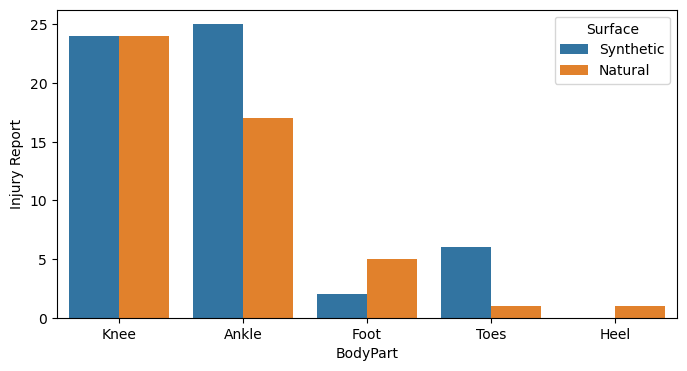

In [33]:
#creating injury chart for each body part based on Grass Type played on Synthetic (Turf) or Natural Grass
plt.figure(figsize=(8, 4))
plt_injury = sns.countplot(data=injury_playlist_merge, x='BodyPart', hue='Surface')
plt_injury.set(ylabel="Injury Report")
plt.show()

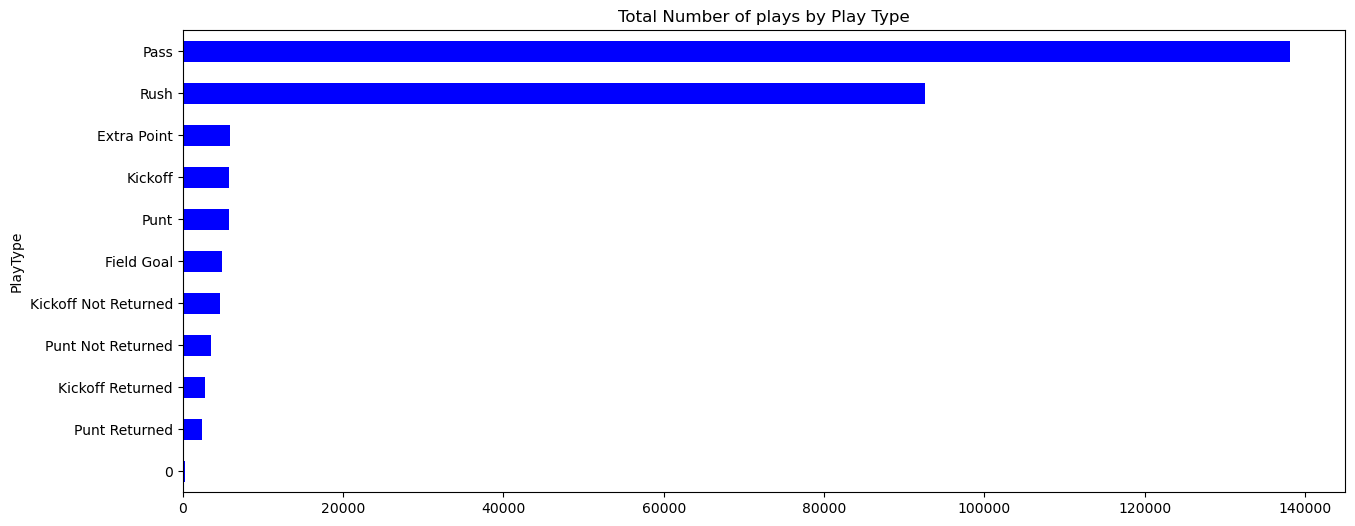

In [34]:
# Injury Report based on Roster Position
# plt.figure(figsize=(14,6))
# plt_injury = sns.countplot(data=injury_playlist_merge, x='RosterPosition', hue='Surface')
# plt_injury.set(ylabel="Injury Report")

playlist_data[['PlayKey', 'PlayType']].drop_duplicates()\
    .groupby('PlayType').count()['PlayKey']\
    .sort_values()\
    .plot(kind='barh',
         figsize=(15, 6),
          color='blue',
         title='Total Number of plays by Play Type')

plt.show()


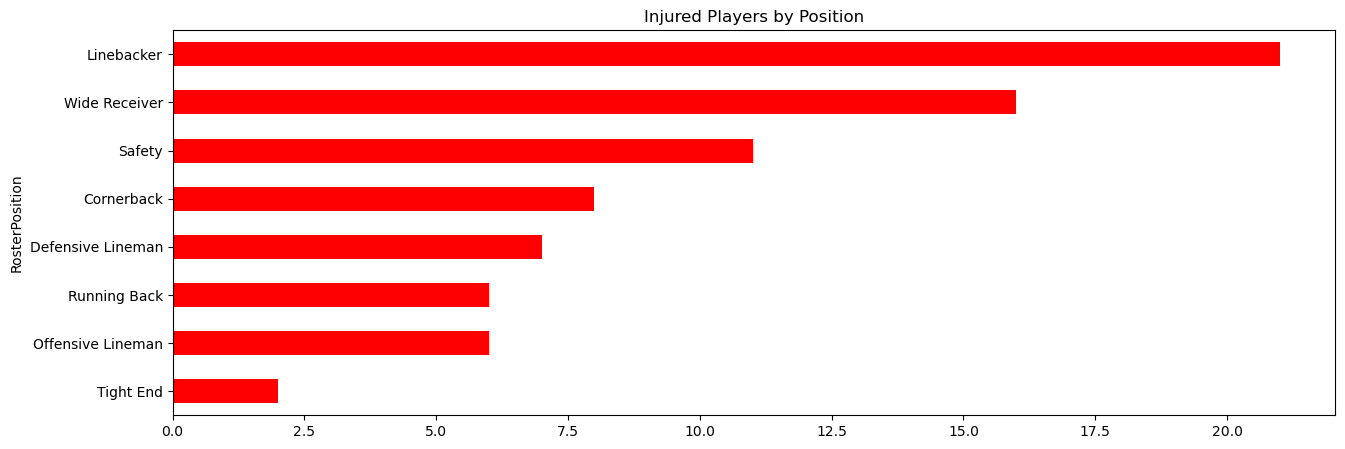

In [35]:
#Injury Report based on PlayType such as Running, Passing
# plt.figure(figsize=(14, 6))
# plt_injury = sns.countplot(data= injury_playlist_merge, x= 'PlayType', hue= 'Surface')
# plt_injury.set(ylabel="Injury Report")

injury_playlist_merge.groupby('RosterPosition').count()['PlayerKey']\
    .sort_values()\
    .plot(figsize=(15, 5), color='red',kind='barh', title='Injured Players by Position')
plt.show()

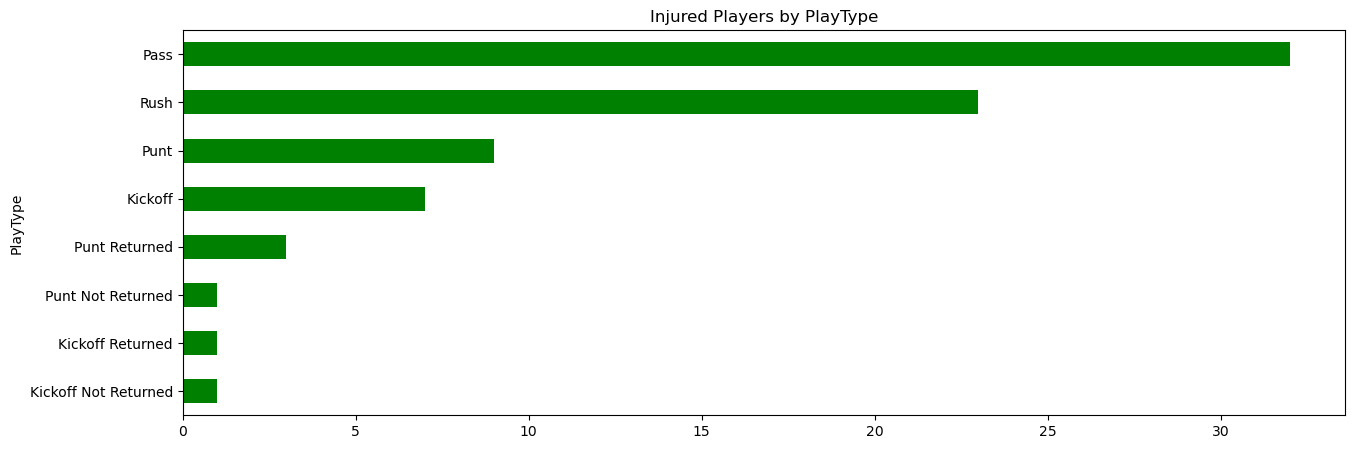

In [36]:
injury_playlist_merge.groupby('PlayType').count()['PlayerKey']\
    .sort_values()\
    .plot(figsize=(15, 5), color='green',kind='barh', title='Injured Players by PlayType')
plt.show()

## Distribution Charts

Creating a Distribution Charts to compare the Types of Injury associated with Player Position, Player Type and Turf Type

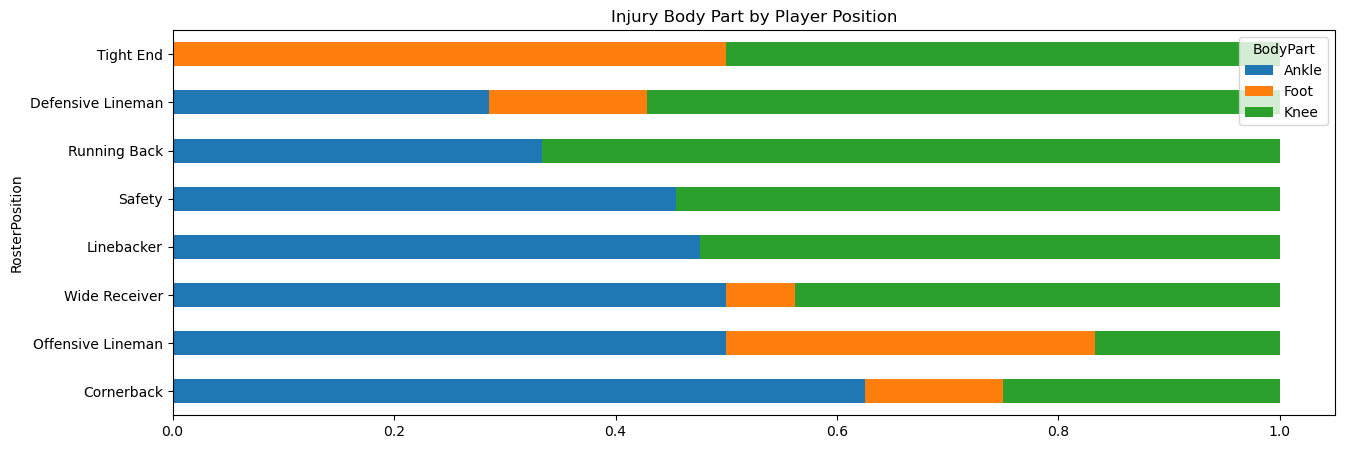

In [37]:
injury_playlist_merge.groupby(['RosterPosition', 'BodyPart']) \
    .count() \
    .unstack('BodyPart')['PlayerKey'] \
    .T.apply(lambda x: x/x.sum()) \
    .sort_values('BodyPart').T.sort_values('Ankle', ascending=False)\
    .plot(kind='barh',
          figsize=(15, 5),
          title='Injury Body Part by Player Position',
          stacked=True)
plt.show()

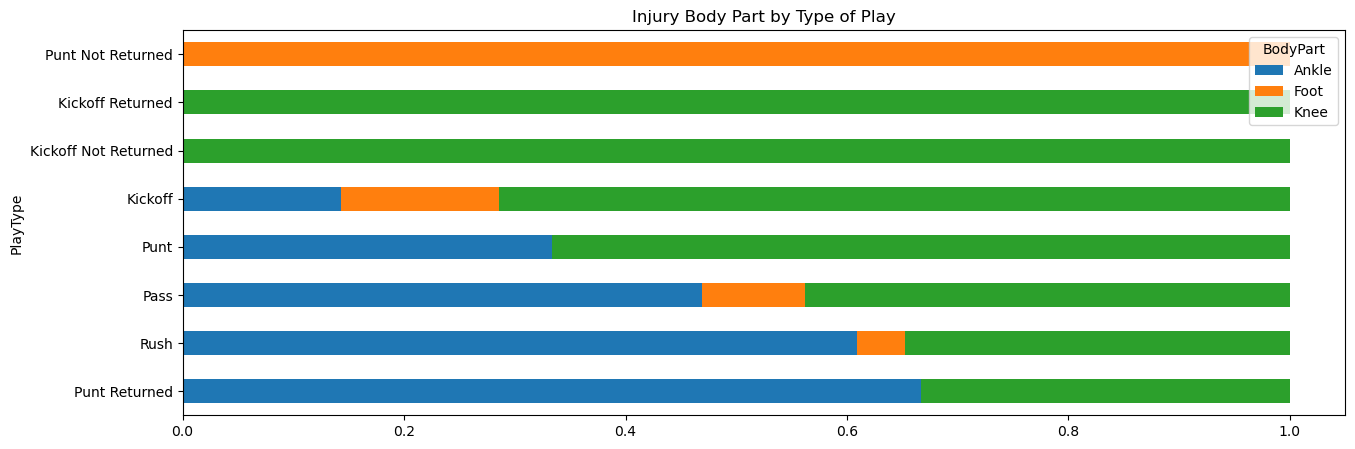

In [38]:
injury_playlist_merge.groupby(['PlayType', 'BodyPart']) \
    .count() \
    .unstack('BodyPart')['PlayerKey'] \
    .T.apply(lambda x: x/x.sum()) \
    .sort_values('BodyPart').T.sort_values('Ankle', ascending=False)\
    .plot(kind='barh',
          figsize=(15, 5),
          title='Injury Body Part by Type of Play',
          stacked=True)
plt.show()

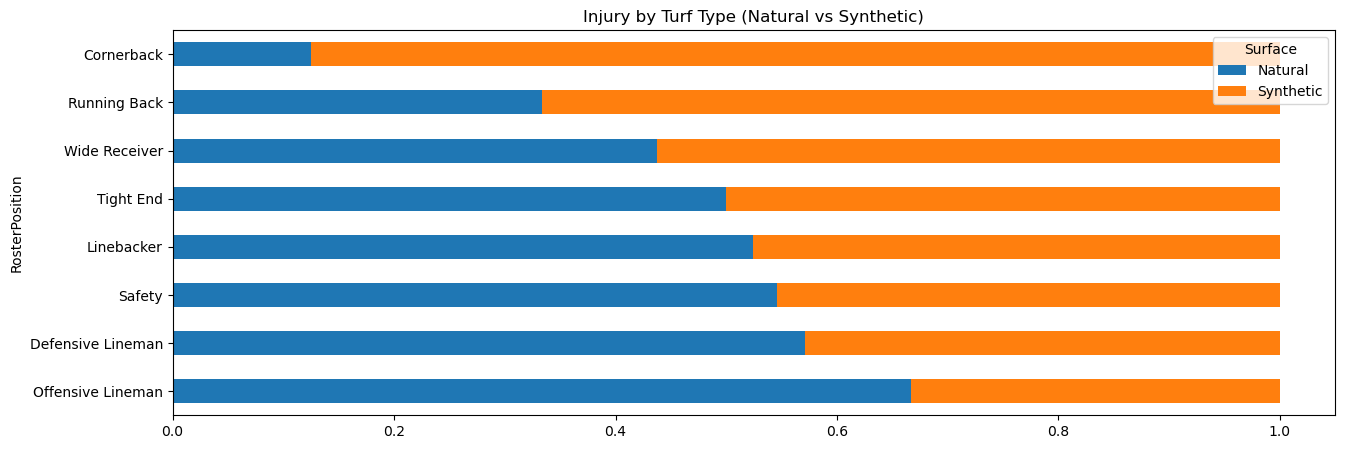

In [39]:
injury_playlist_merge.groupby(['RosterPosition', 'Surface']) \
    .count() \
    .unstack('Surface')['PlayerKey'] \
    .T.apply(lambda x: x/x.sum()) \
    .sort_values('Surface').T.sort_values('Natural', ascending=False)\
    .plot(kind='barh',
          figsize=(15, 5),
          title='Injury by Turf Type (Natural vs Synthetic)',
          stacked=True)
plt.show()

## Hazard Rate Model 

Model uses to determines the likelihood of an player subject to injury based on conditions (Turf Types, Open Stadium Type and Weather Conditions)

Models possibly be used in following: 

**Kaplan-Meier Estimate (Curve)**

**Cox Proportional Hazard Model**

**Logistic Regression**



In [46]:
# validating the df tables  for natural grass type needed to create this model
nat_grass_type.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0,Linebacker,50.0,7.0,Open,Natural,76.0,Partly Cloudy,Punt,26.0,OLB,LB
1,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0,Linebacker,15.0,3.0,Outdoor,Natural,80.0,Cloudy,Punt,30.0,LB,LB
2,41145,41145-2,41145-2-60,Knee,Natural,1,0,0,0,Safety,11.0,2.0,Outdoor,Natural,89.0,Sunny,Pass,60.0,SS,DB
3,44860,44860-5,44860-5-52,Knee,Natural,1,1,0,0,Linebacker,29.0,5.0,Outdoor,Natural,67.0,Cloudy,Rush,52.0,OLB,LB
4,36621,36621-13,36621-13-58,Foot,Natural,1,1,1,1,Offensive Lineman,92.0,13.0,Dome,Natural,79.0,NaN,Rush,58.0,T,OL


In [47]:
#validating the df table for synthetic grass type needed to create this model
syn_grass_type.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1,Linebacker,29.0,4.0,Indoors,Synthetic,84.0,Cloudy,Punt,32.0,OLB,LB
1,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1,Safety,1.0,1.0,Outdoor,Synthetic,63.0,Clear and warm,Pass,70.0,SS,DB
2,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1,Wide Receiver,32.0,5.0,Retractable Roof,Synthetic,89.0,Partly Cloudy,Kickoff,69.0,WR,WR
3,46014,46014-10,46014-10-22,Ankle,Synthetic,1,1,1,1,Running Back,71.0,10.0,Retractable Roof,Synthetic,60.0,Sunny,Rush,22.0,RB,RB
4,44806,44806-7,44806-7-61,Knee,Synthetic,1,0,0,0,Linebacker,43.0,7.0,Indoor,Synthetic,-999.0,Indoor,Rush,61.0,ILB,LB


**The Kaplan-Meier curve** 
    
Using the KaplanMeierFitter to gather sample data for Natural Turf


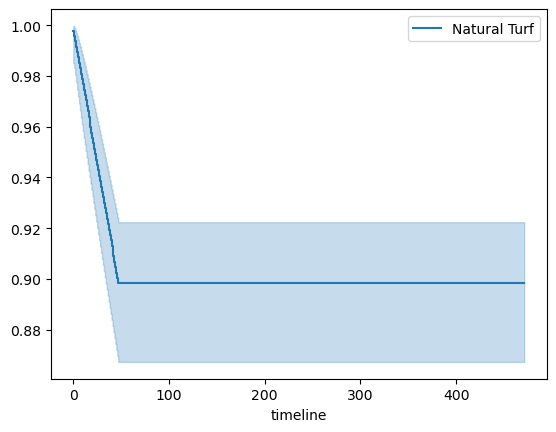

In [101]:
# Create duration to calculate number of days played 
durations_1 = list(range(int(max(nat_grass_type['PlayerDay'].dropna()))+1))
# append 1 if number of days played else append 0 otherwise
event_observed_1 = [1 if dur in nat_grass_type['PlayerDay'] else 0 for dur in durations_1]
# using kmf.fit to fit the player day data to the model
kmf.fit(durations_1, event_observed_1, label="Natural Turf")
# display the plot (NOTE: ci_show uses to display the confidence interval)
data1 = kmf.plot()

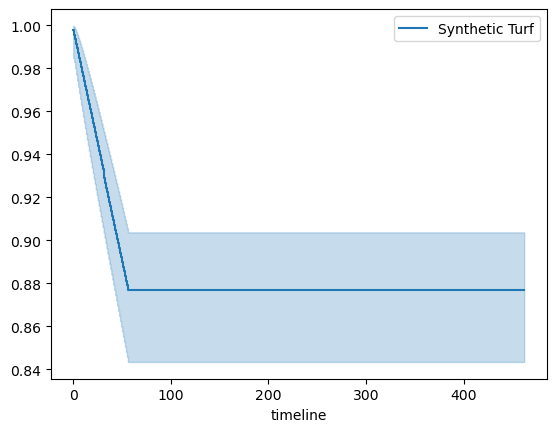

In [69]:
# creating second KaplanMeierFitter plot for synthetic grass 
durations_2 = list(range(int(max(syn_grass_type['PlayerDay'].dropna()))+1))
event_observed_2 = [1 if dur in syn_grass_type['PlayerDay'] else 0 for dur in durations_2]
kmf.fit(durations_2, event_observed_2, label="Synthetic Turf")
data2 = kmf.plot(ci_show=False)

In [99]:
injury_playlist_merge.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1,Linebacker,29.0,4.0,Indoors,Synthetic,84.0,Cloudy,Punt,32.0,OLB,LB
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0,Linebacker,50.0,7.0,Open,Natural,76.0,Partly Cloudy,Punt,26.0,OLB,LB
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1,Safety,1.0,1.0,Outdoor,Synthetic,63.0,Clear and warm,Pass,70.0,SS,DB
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0,Linebacker,15.0,3.0,Outdoor,Natural,80.0,Cloudy,Punt,30.0,LB,LB
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1,Wide Receiver,32.0,5.0,Retractable Roof,Synthetic,89.0,Partly Cloudy,Kickoff,69.0,WR,WR


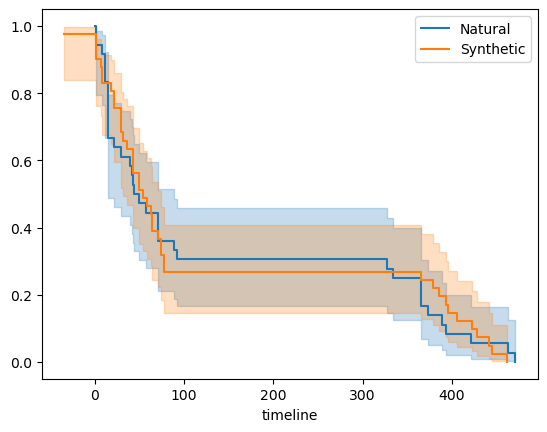

In [98]:
# create KaplanMeierFitter to compare the two grass turf types within single plot
# using Kaplan Meier Curves to analyze time until the event (i.e. displaying number of days played until injury occurs)
D = injury_playlist_merge['PlayerDay'].dropna()
E = injury_playlist_merge['PlayerDay'].dropna()

grass_type = injury_playlist_merge['Surface']
nat = (grass_type == 'Natural')
syn = (grass_type == 'Synthetic')

kmf.fit(D[nat], E[nat],label='Natural')
ax1 = kmf.plot()

kmf.fit(D[syn], E[syn], label='Synthetic')
ax2 = kmf.plot(ax = ax1)

**Cox Proportional Hazard Model**   

Using to determine injury factors that may influence the prediction hazard model

NOTE: Cox takes into account the effect of several variables at a time and examines the relationship of the survival distribution to these variables

ALSO NOTE: is essentially a regression model commonly used statistical in medical research for investigating the association between the survival time of patients and one or more predictor variables.

In [102]:
#creating an dummy dataframe from the injury playlist table
df_dummy = pd.get_dummies(injury_playlist_merge, drop_first=True)
df_dummy.head()

,PlayerKey,DM_M1,DM_M7,DM_M28,DM_M42,PlayerDay,PlayerGame,Temperature,PlayerGamePlay,GameID_31933-20,...,Position_SS,Position_T,Position_TE,Position_WR,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_RB,PositionGroup_TE,PositionGroup_WR
0,39873,1,1,1,1,29.0,4.0,84.0,32.0,False,...,False,False,False,False,False,True,False,False,False,False
1,46074,1,1,0,0,50.0,7.0,76.0,26.0,False,...,False,False,False,False,False,True,False,False,False,False
2,36557,1,1,1,1,1.0,1.0,63.0,70.0,False,...,True,False,False,False,False,False,False,False,False,False
3,46646,1,0,0,0,15.0,3.0,80.0,30.0,False,...,False,False,False,False,False,True,False,False,False,False
4,43532,1,1,1,1,32.0,5.0,89.0,69.0,False,...,False,False,False,True,False,False,False,False,False,True


In [109]:
# Setting up an new column
dummy_table = pd.Series(playlist_data[['PlayerKey', 'GameID', 'PlayKey']].itertuples(index=False, name=None)).\
    isin(injury_data[['PlayerKey', 'GameID', 'PlayKey']].itertuples(index=False, name=None))*1
#add new column injury indication factor to playlist table
playlist_data['inj_ind'] = dummy_table

playlist_data.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup,inj_ind
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB,0
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB,0
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB,0
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB,0
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB,0


In [111]:
#setup categorical values for the playlist column for StadiumType, FieldType, Weather, Playtype and Position

playlist_data.StadiumType = pd.Categorical(playlist_data.StadiumType)
playlist_data['StadiumType_Code'] = playlist_data.StadiumType.cat.codes

playlist_data.FieldType = pd.Categorical(playlist_data.FieldType)
playlist_data['FieldType_Code'] = playlist_data.StadiumType.cat.codes

playlist_data.Weather = pd.Categorical(playlist_data.Weather)
playlist_data['Weather_Code'] = playlist_data.Weather.cat.codes

playlist_data.PlayType = pd.Categorical(playlist_data.PlayType)
playlist_data['PlayType_Code'] = playlist_data.PlayType.cat.codes

playlist_data.Position = pd.Categorical(playlist_data.Position)
playlist_data['Position_Code'] = playlist_data.Position.cat.codes


In [112]:
playlist_data.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup,inj_ind,StadiumType_Code,FieldType_Code,Weather_Code,PlayType_Code,Position_Code
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,8,Pass,1,QB,QB,0,18,18,9,6,16
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,8,Pass,2,QB,QB,0,18,18,9,6,16
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,8,Rush,3,QB,QB,0,18,18,9,10,16
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,8,Rush,4,QB,QB,0,18,18,9,10,16
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,8,Pass,5,QB,QB,0,18,18,9,6,16


In [116]:
#Displays CoxPHFitter Data Summary Based on the Factors noting the number of observations from the data collected and events occurred 
features = ['Injury','Multiplier', 'FieldType', 'Temperature', 'StadiumType', 'PlayerDay','PlayType_Code','Position_Code' ]
X = agg_merge_play_inj[features]
cph.fit(X, 'PlayerDay', event_col= 'Injury')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 273337 total observations, 185081 right-censored observations>
             duration col = 'PlayerDay'
                event col = 'Injury'
      baseline estimation = breslow
   number of observations = 273337
number of events observed = 88256
   partial log-likelihood = -1015042.45
         time fit was run = 2024-01-21 17:51:23 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
Multiplier      0.14       1.15       0.02             0.09             0.18                 1.10                 1.20
FieldType      -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
Temperature     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
StadiumType    -0.07       0.93       0.01            -0.09            -0.06                 0.92                 0.94
PlayType_Code  -0.02       0.98       0.00            -0.02            -0.02                 0.98                 0.98
Position_Code   0.01       1.01       0.00             0.01             0.01                 1.01                 1.01

                cmp to      z      p   -log2(p)
covariate                                      
Multiplier        0.00   6.23 <0.005      31.01
FieldType         0.00  -0.98   0.33       1.60
Temperature       0.00   2.10   0.04       4.79
StadiumType       0.00  -9.44 <0.005      67.84
PlayType_Code     0.00 -13.32 <0.005     132.11
Position_Code     0.00  23.57 <0.005     405.72
---
Concordance = 0.53
Partial AIC = 2030096.90
log-likelihood ratio test = 878.14 on 6 df
-log2(p) of ll-ratio test = 616.88

**Logistic Regression**

A statistical analysis method to predict a binary outcome, such as yes or no, based on prior observations of a data set

In [125]:
# assign set of column tables to features variable except Injury column is not listed
features = ['Multiplier', 'FieldType', 'Temperature', 'StadiumType', 'PlayerDay','PlayType_Code','Position_Code' ]
# include features variable assigned as X variable and Injury Column seprately as Y variable
X = agg_merge_play_inj[features]
Y = agg_merge_play_inj['Injury']
# create four variables for Test and Train Models for both X and Y variables
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.15, random_state=42)
clf = LogisticRegression(random_state=0).fit(X_Train, Y_Train)
y_predict_log = clf.predict(X_Test)


In [126]:
#display the Logic Regression score for both X and Y value from 0 to 100
clf.score(X_Test, Y_Test)

0.6772273846979342

In [127]:
#outputs the size and direction of the relationship between predictor and response variable
clf.coef_

array([[-0.02276192, -0.02542065,  0.00022573, -0.20741035,  0.00023397,
        -0.0183592 ,  0.00970569]])

Text(0.5, 427.9555555555555, 'Predicted Label')

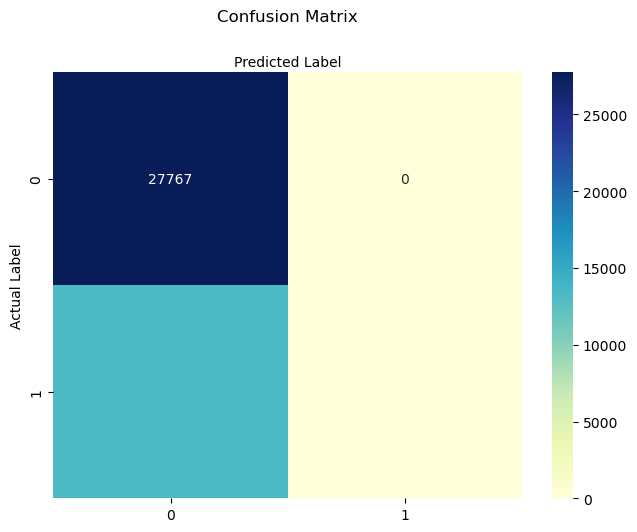

In [132]:
# implemented sklearn metrics libaray to utilize the confusion matrix
# NOTE: matrix (NxN) table used for evaluating the performance of a classification model, where N is the total number of target classes
cnf_matrix = metrics.confusion_matrix(Y_Test, y_predict_log)
class_names = [0, 1] # sets name of class
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names)) #implement the class names 
#append tick marks and class names to the plot matrix
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
#setup and create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

In [135]:
# implemening the RandomForestClassifer 

# assign set of column tables to features variable except Injury column is not listed
features = ['Multiplier', 'FieldType', 'Temperature', 'StadiumType', 'PlayerDay','PlayType_Code','Position_Code' ]
# include features variable assigned as X variable and Injury Column seprately as Y variable
X = agg_merge_play_inj[features]
Y = agg_merge_play_inj['Injury']
# create four variables for Test and Train Models for both X and Y variables
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.15, random_state=42)
clf = RandomForestClassifier(random_state=0).fit(X_Train, Y_Train)
y_predict_log = clf.predict(X_Test)

In [136]:
clf.score(X_Test, Y_Test)

0.939977073729909

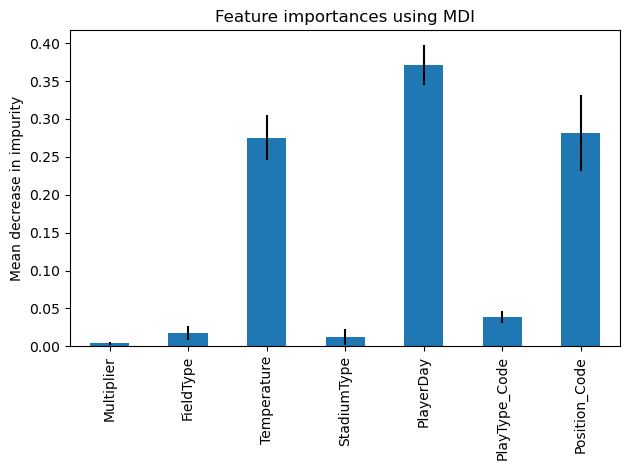

In [138]:
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=features)
std_dev = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std_dev, ax=ax)
ax.set_title("Feature importances using MDI") # assigns the score of input features based on their importance to predict the output.
ax.set_ylabel("Mean decrease in impurity") # impurity the quality or condition of being impure.
fig.tight_layout()

Player Day appears to be the most impactful out of the other factors 